In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS10EC_d_t3_03.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS7EC_d_cz_08.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS10EC_d_f8_05.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS9EC_d_cz_04.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS5EC_d_c4_07.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS2EC_d_f4_01.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS15EC_d_p3_03.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS6EC_d_f7_09.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS14EC_d_cz_06.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS6EC_d_o1_02.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS3EC_d_f8_01.jpg
/kaggle/input/data-egg/datset-egg/data_resized/Responders/r_sw_am_RS1EC_

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image

2024-05-20 03:05:41.219143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 03:05:41.219244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 03:05:41.394270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define the base path
base_path = "/kaggle/input/data-egg/datset-egg/data_resized"

# Initialize lists to store paths and labels
paths = []
labels = []

# Traverse through the folders and collect paths and labels
for folder in ["Responders", "Non_Responders"]:
    folder_path = os.path.join(base_path, folder)
    
    # Iterate through files in the folder
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        
        # Append path and label to the lists
        paths.append(file_path)
        labels.append(folder)

# Create a DataFrame
df = pd.DataFrame({"path": paths, "label": labels})

# Display the DataFrame
df


,path,label
0,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
1,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
2,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
3,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
4,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
...,...,...
5410,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5411,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5412,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders
5413,/kaggle/input/data-egg/datset-egg/data_resized...,Non_Responders


In [5]:
df["label"].value_counts()

label
Non_Responders    3249
Responders        2166
Name: count, dtype: int64

In [6]:
df.to_csv("EEG_Scalagram_Dataset.csv", index=False)

In [7]:
df = pd.read_csv("EEG_Scalagram_Dataset.csv")
df.head()

,path,label
0,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
1,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
2,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
3,/kaggle/input/data-egg/datset-egg/data_resized...,Responders
4,/kaggle/input/data-egg/datset-egg/data_resized...,Responders


In [8]:
df["label"].value_counts()

label
Non_Responders    3249
Responders        2166
Name: count, dtype: int64

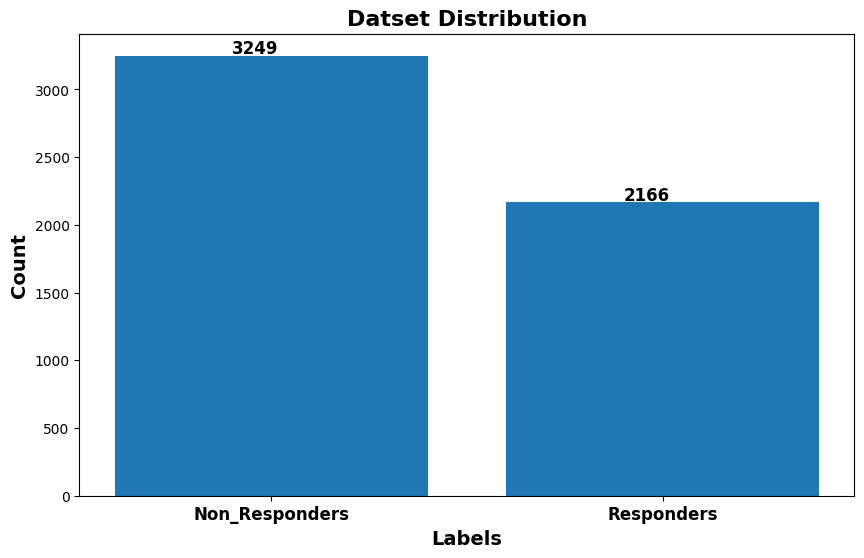

In [9]:
label_counts = df["label"].value_counts()

# Plotting the bar plot with count representation
fig, ax = plt.subplots(figsize=(10, 6)) 
bars = plt.bar(label_counts.index, label_counts.values, linewidth=1.5)

# Customize x-label and y-label size
plt.xlabel('Labels', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Customize x-tick labels size and make them bold
plt.xticks(fontsize=12, fontweight='bold')

# Increase space between bars and count numbers
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 15, str(count), fontsize=12, fontweight='bold')

# Add a border to the bars
for bar in bars:
    bar.set_linewidth(1.5)

# Title of the plot
plt.title('Datset Distribution', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Calculate the number of images for each class in the test set
test_size_percent = 0.1
num_responders_test = round(2166 * test_size_percent)  # Round to the nearest integer
num_non_responders_test = round(3249 * test_size_percent)  # Round to the nearest integer

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=test_size_percent, stratify=df['label'], random_state=42)

# Displaying the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Print the number of images in each class for the test set
print("Number of Responders in Test Set:", num_responders_test)
print("Number of Non_Responders in Test Set:", num_non_responders_test)


Train set shape: (4873, 2)
Test set shape: (542, 2)
Number of Responders in Test Set: 217
Number of Non_Responders in Test Set: 325


In [11]:
from sklearn.model_selection import StratifiedKFold

# Set up StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation sets
fold_train_dfs = []
fold_val_dfs = []

# Split the training set into 5 folds
for train_index, val_index in skf.split(train_df['path'], train_df['label']):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]
    
    # Append to the lists
    fold_train_dfs.append(train_fold)
    fold_val_dfs.append(val_fold)

# Print the number of images in each class for each fold
for fold, (train_fold, val_fold) in enumerate(zip(fold_train_dfs, fold_val_dfs), 1):
    print(f"Fold {fold} - Training Set Class Distribution:")
    print(train_fold['label'].value_counts())
    print(f"\nFold {fold} - Validation Set Class Distribution:")
    print(val_fold['label'].value_counts())
    print("\n" + "-"*40)


Fold 1 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 1 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 2 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 2 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 3 - Training Set Class Distribution:
label
Non_Responders    2339
Responders        1559
Name: count, dtype: int64

Fold 3 - Validation Set Class Distribution:
label
Non_Responders    585
Responders        390
Name: count, dtype: int64

----------------------------------------
Fold 4 - Training Set Class Distribution:
label
Non_Responders    2340
Responders        1559
Name: count, dtype: int64

Fold 4 - Validation Set Class 

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
from keras.applications import Xception
# Define the input shape
input_shape = (224, 224, 3)

# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
# Add a global average pooling layer, BatchNormalization, and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model 

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,871,721 (79.62 MB)

 Trainable params: 20,813,097 (79.40 MB)

 Non-trainable params: 58,624 (229.00 KB)

In [15]:
# Initialize EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Fold 1
Start Time: 2024-05-20 03:06:05
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716174447.272571     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 193s 936ms/step - accuracy: 0.6986 - loss: 0.5717 - val_accuracy: 0.6974 - val_loss: 0.6459
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 443ms/step - accuracy: 0.9274 - loss: 0.1807 - val_accuracy: 0.8626 - val_loss: 0.4258
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9582 - loss: 0.1063 - val_accuracy: 0.9067 - val_loss: 0.2453
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 440ms/step - accuracy: 0.9733 - loss: 0.0727 - val_accuracy: 0.9282 - val_loss: 0.2053
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - accuracy: 0.9841 - loss: 0.0493 - val_accuracy: 0.9487 - val_loss: 0.1430
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 445ms/step - accuracy: 0.9713 - loss: 0.0762 - val_accuracy: 0.8923 - val_loss: 0.3135
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9766 - loss: 0.0701 - val_accuracy: 0.9569 - val_loss: 0.1218
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9808 - loss: 0.0474 - va

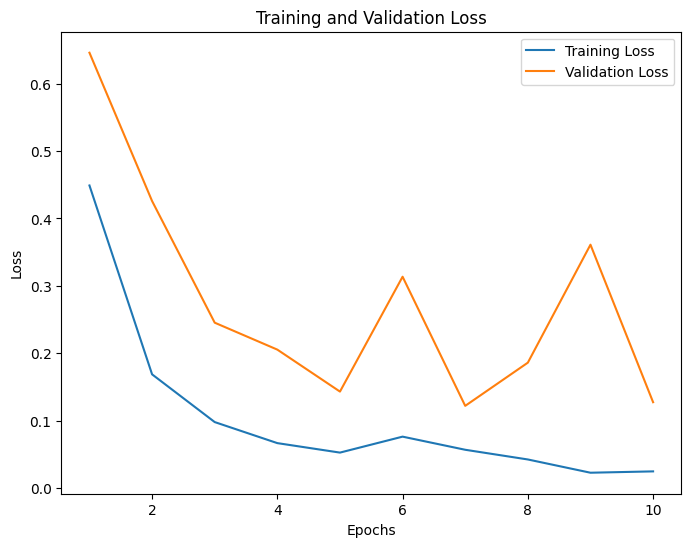

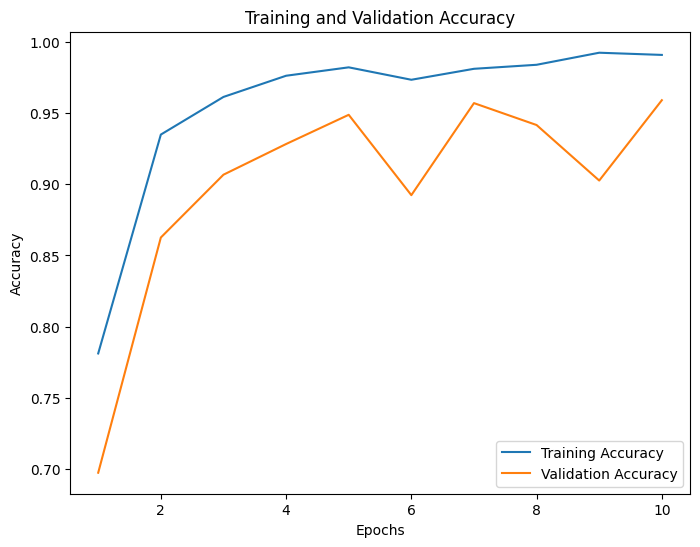

Fold 2
Start Time: 2024-05-20 03:17:35
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 446ms/step - accuracy: 0.9687 - loss: 0.0889 - val_accuracy: 0.9877 - val_loss: 0.0311
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9894 - loss: 0.0301 - val_accuracy: 0.9867 - val_loss: 0.0384
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 444ms/step - accuracy: 0.9877 - loss: 0.0274 - val_accuracy: 0.9949 - val_loss: 0.0190
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9944 - loss: 0.0210 - val_accuracy: 0.9959 - val_loss: 0.0097
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9923 - loss: 0.0224 - val_accuracy: 0.9826 - val_loss: 0.0471
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 444ms/step - accuracy: 0.9947 - loss: 0.0128 - val_accuracy: 0.9928 - val_loss: 0.0204
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - accuracy: 0.9917 - loss: 0.0262 - val_accuracy: 0.9764 - val_loss: 0.0542
End Time: 2024-05-20 03:24:01
Elapsed Time for Fold 2: 385.53 seconds

Training Loss: [0.09600

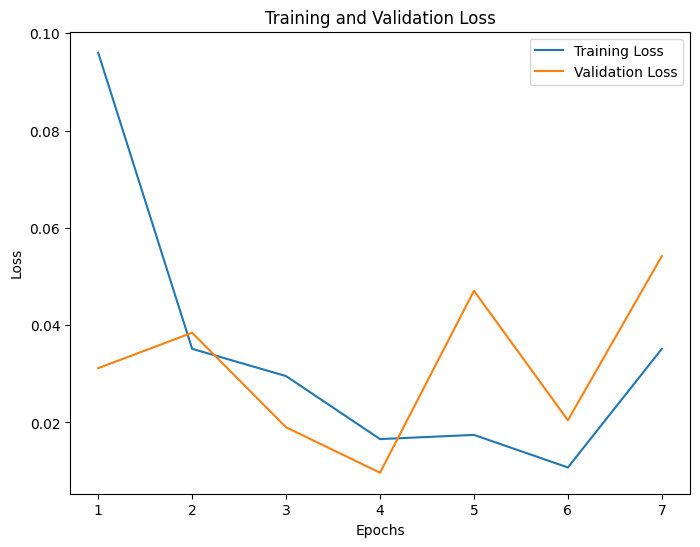

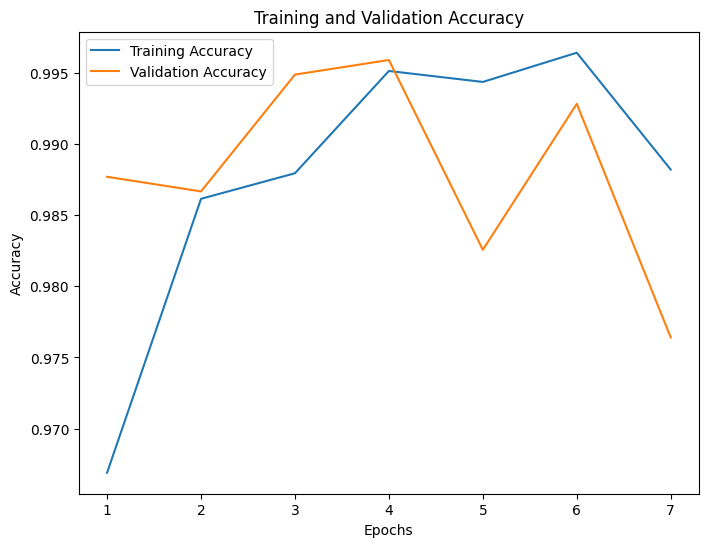

Fold 3
Start Time: 2024-05-20 03:24:02
Found 3898 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 975 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 446ms/step - accuracy: 0.9931 - loss: 0.0208 - val_accuracy: 0.9928 - val_loss: 0.0263
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 440ms/step - accuracy: 0.9794 - loss: 0.0614 - val_accuracy: 0.9908 - val_loss: 0.0270
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9927 - loss: 0.0202 - val_accuracy: 0.9559 - val_loss: 0.1657
End Time: 2024-05-20 03:26:47
Elapsed Time for Fold 3: 165.26 seconds

Training Loss: [0.03678722307085991, 0.05365200713276863, 0.01738816127181053]
Validation Loss: [0.026278048753738403, 0.02703351527452469, 0.16569754481315613]
Training Accuracy: [0.9874294400215149, 0.9820420742034912, 0.9935864806175232]
Validation Accuracy: [0.9928205013275146, 0.9907692074775696, 0.9558974504470825]


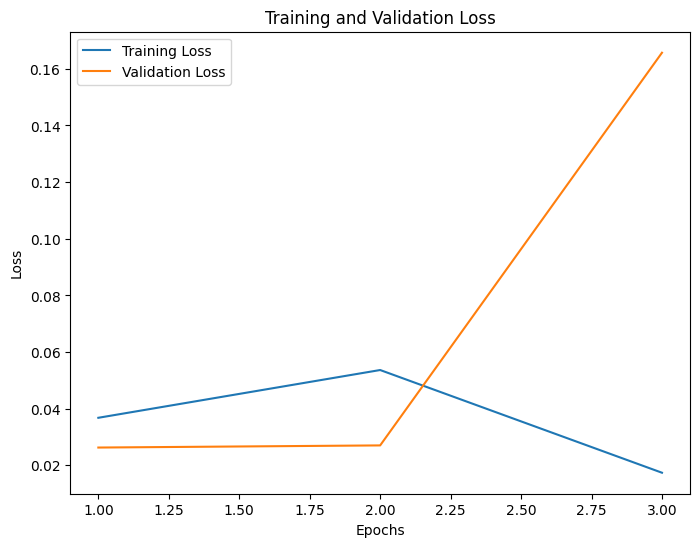

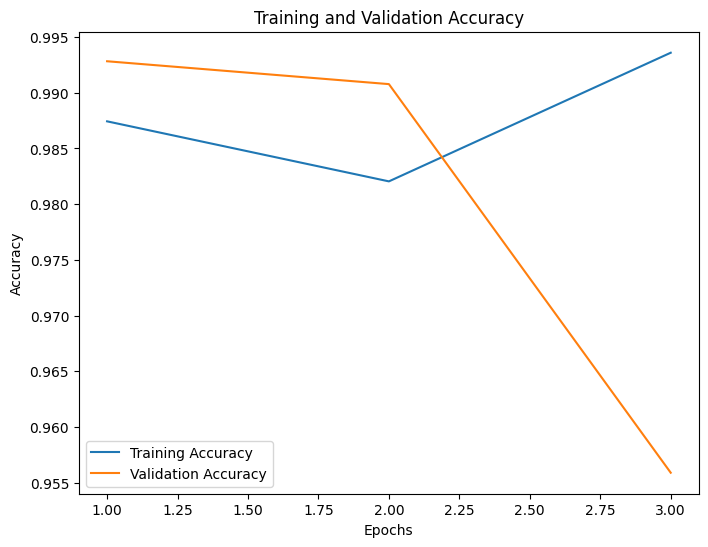

Fold 4
Start Time: 2024-05-20 03:26:47
Found 3899 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 974 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 110s 899ms/step - accuracy: 0.9884 - loss: 0.0377 - val_accuracy: 0.9856 - val_loss: 0.0302
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - accuracy: 0.9876 - loss: 0.0443 - val_accuracy: 0.9959 - val_loss: 0.0164
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 444ms/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.9610 - val_loss: 0.2204
End Time: 2024-05-20 03:30:29
Elapsed Time for Fold 4: 221.97 seconds

Training Loss: [0.04508407041430473, 0.037512753158807755, 0.022118983790278435]
Validation Loss: [0.030237214639782906, 0.01644110679626465, 0.22035367786884308]
Training Accuracy: [0.9838420152664185, 0.9889715313911438, 0.9920492172241211]
Validation Accuracy: [0.9856262803077698, 0.9958932399749756, 0.9609856009483337]


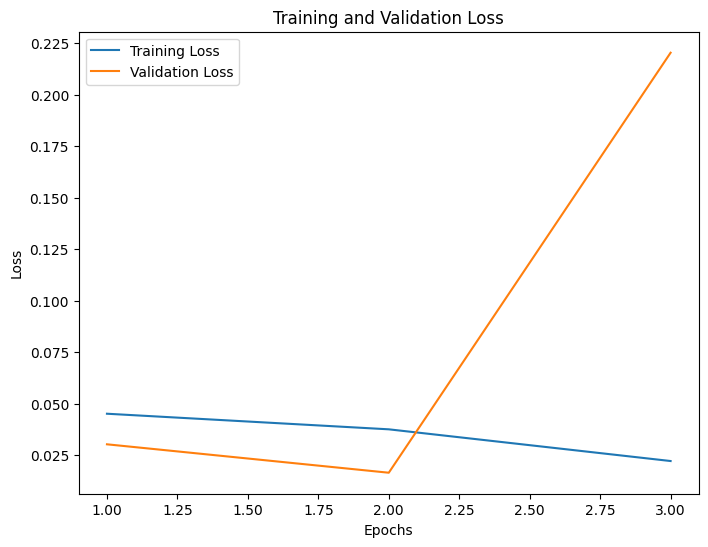

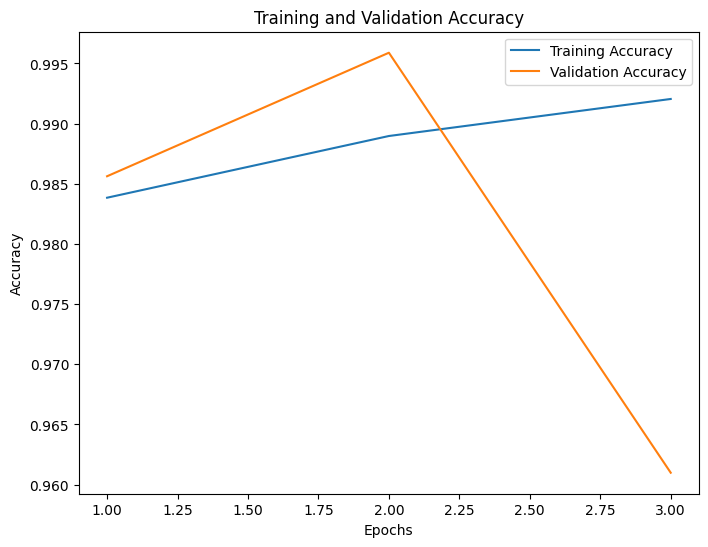

Fold 5
Start Time: 2024-05-20 03:30:30
Found 3899 validated image filenames belonging to 2 classes.
train_generator classes {'Non_Responders': 0, 'Responders': 1}
Found 974 validated image filenames belonging to 2 classes.
val_generator classes {'Non_Responders': 0, 'Responders': 1}
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 443ms/step - accuracy: 0.9899 - loss: 0.0241 - val_accuracy: 0.9189 - val_loss: 0.2305
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 441ms/step - accuracy: 0.9922 - loss: 0.0284 - val_accuracy: 0.9836 - val_loss: 0.0385
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 442ms/step - accuracy: 0.9938 - loss: 0.0170 - val_accuracy: 0.9959 - val_loss: 0.0129
End Time: 2024-05-20 03:33:15
Elapsed Time for Fold 5: 165.27 seconds

Training Loss: [0.03114018216729164, 0.02203783020377159, 0.02020215429365635]
Validation Loss: [0.2305281162261963, 0.038452453911304474, 0.012921790592372417]
Training Accuracy: [0.9889715313911438, 0.9938445687294006, 0.9935880899429321]
Validation Accuracy: [0.918891191482544, 0.9835729002952576, 0.9958932399749756]


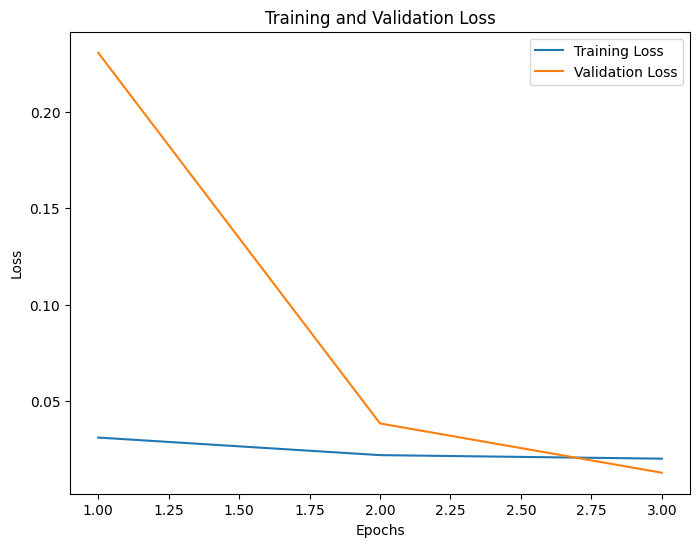

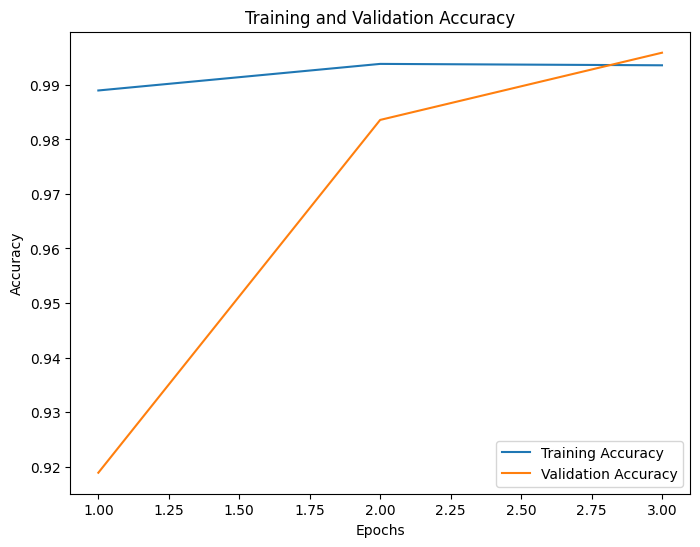

Total Training Time: 1628.13 seconds


In [16]:
# Number of epochs and batch size
epochs = 10
batch_size = 32

# Initialize lists to store loss and accuracy values
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize lists to store start and end times
all_start_times = []
all_end_times = []

# Loop through the folds and fit the model
for i in range(5):
    print("Fold", i + 1)

    # Record the start time for the current fold
    start_time = time.time()
    all_start_times.append(start_time)
    print("Start Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

    # Get the current fold's training and validation sets
    fold_train = fold_train_dfs[i]
    fold_val = fold_val_dfs[i]

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=fold_train,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='binary'
    )
    print("train_generator classes", train_generator.class_indices)

    # Validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=fold_val,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='binary'
    )
    print("val_generator classes", val_generator.class_indices)

    # Fit the model on the current fold's training and validation data
    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        callbacks=[early_stop]
    )

    # Record the end time for the current fold
    end_time = time.time()
    all_end_times.append(end_time)
    print("End Time:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))

    # Calculate and print the elapsed time for the current fold
    elapsed_time = end_time - start_time
    print("Elapsed Time for Fold {}: {:.2f} seconds\n".format(i + 1, elapsed_time))

    # Print the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Append the loss and accuracy values to the lists
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(history.epoch) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(history.epoch) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Calculate and print the total training time
total_training_time = sum(all_end_times) - sum(all_start_times)
print("Total Training Time: {:.2f} seconds".format(total_training_time))

In [17]:
# Calculate and print the average loss and accuracy
avg_train_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_train_loss]
avg_val_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_val_loss]
avg_train_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_train_acc]
avg_val_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_val_acc]

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)
print("Average Training Accuracy:", avg_train_acc)
print("Average Validation Accuracy:", avg_val_acc)

Average Training Loss: [0.1056456645950675, 0.03436226663844926, 0.035942463825146355, 0.03490526912113031, 0.02446005555490653]
Average Validation Loss: [0.27748801186680794, 0.031418690857078345, 0.07300303628047307, 0.08901066643496354, 0.0939674535766244]
Average Training Accuracy: [0.9556695699691773, 0.9878692371504647, 0.9876859982808431, 0.9882875879605612, 0.9921347300211588]
Average Validation Accuracy: [0.8995897471904755, 0.9881318637302944, 0.9798290530840555, 0.9808350404103597, 0.966119110584259]


In [18]:
# Calculate and print the average loss and accuracy
mean_train_loss = sum(avg_train_loss) / len(avg_train_loss)
mean_val_loss = sum(avg_val_loss) / len(avg_val_loss)
mean_train_acc = sum(avg_train_acc) / len(avg_train_acc)
mean_val_acc = sum(avg_val_acc) / len(avg_val_acc)

print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Accuracy:", mean_val_acc)


Mean Training Loss: 0.047063143946939986
Mean Validation Loss: 0.11297757180318943
Mean Training Accuracy: 0.982329424676441
Mean Validation Accuracy: 0.9629009629998888


In [19]:
# Record start time
start_time = time.time()

# Setting the test set as the final evaluation set
evaluation_set = test_df

# Print the length of the evaluation set
print("Evaluation set length:", len(evaluation_set))

# Evaluate the model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='binary'
)
print("evaluation_generator classes", evaluation_generator.class_indices)

evaluation_loss, evaluation_accuracy = model.evaluate(evaluation_generator)

# Record end time
end_time = time.time()

# Calculate and print the time taken for evaluation
elapsed_time = end_time - start_time
print("Time taken for evaluation:", elapsed_time, "seconds")

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Evaluation set length: 542
Found 542 validated image filenames belonging to 2 classes.
evaluation_generator classes {'Non_Responders': 0, 'Responders': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8776 - loss: 0.3760 
Time taken for evaluation: 18.525412559509277 seconds
Evaluation Loss: 0.4792933762073517
Evaluation Accuracy: 0.8597785830497742


In [20]:
# After training, save the model
model.save('MDD_Xception.h5')
print("Model saved successfully")

Model saved successfully


### Performanc Evaluation

In [21]:
# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
evaluation_pred_classes = (evaluation_predictions > 0.5).astype(int)  

# Get true labels
true_labels = evaluation_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, evaluation_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)



# Calculate classification report
class_report = classification_report(true_labels, evaluation_pred_classes)
print("Classification Report:")
print(class_report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step
Confusion Matrix:
[[254  71]
 [  5 212]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       325
           1       0.75      0.98      0.85       217

    accuracy                           0.86       542
   macro avg       0.86      0.88      0.86       542
weighted avg       0.89      0.86      0.86       542



In [23]:
# Calculate classification report
class_report = classification_report(true_labels, evaluation_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       325
           1       0.75      0.98      0.85       217

    accuracy                           0.86       542
   macro avg       0.86      0.88      0.86       542
weighted avg       0.89      0.86      0.86       542



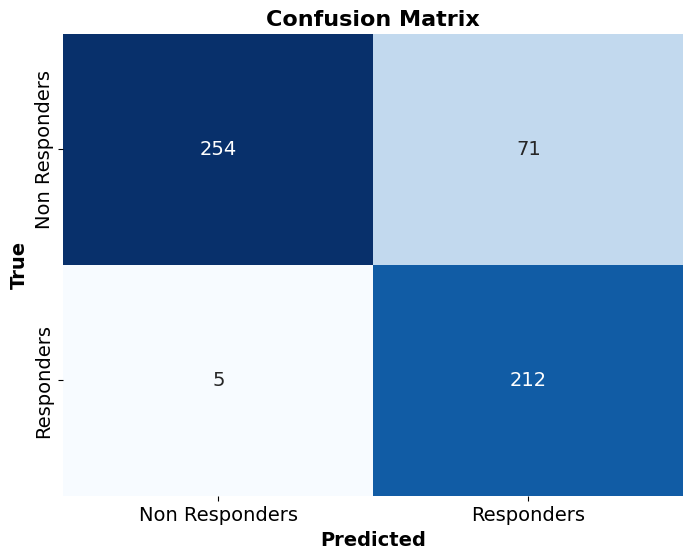

In [24]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14})
    
    # Increase font size for class labels
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    
    plt.xlabel('Predicted', fontsize=14, weight='bold')  # Increase font size and weight for x label
    plt.ylabel('True', fontsize=14, weight='bold')  # Increase font size and weight for y label
    plt.title('Confusion Matrix', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

# Assuming you already have the confusion matrix (conf_matrix) and class names
class_names = ['Non Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)


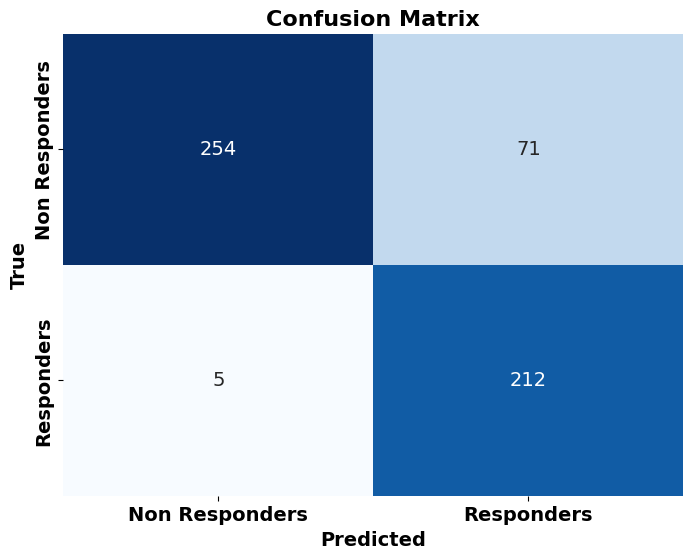

In [25]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14})
    
    # Increase font size and make class labels bold
    ax.set_xticklabels(class_names, fontsize=14, weight='bold')
    ax.set_yticklabels(class_names, fontsize=14, weight='bold')
    
    plt.xlabel('Predicted', fontsize=14, weight='bold')  
    plt.ylabel('True', fontsize=14, weight='bold')  # Increase font size and weight for y label
    plt.title('Confusion Matrix', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

#  confusion matrix (conf_matrix) and class names
class_names = ['Non Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)


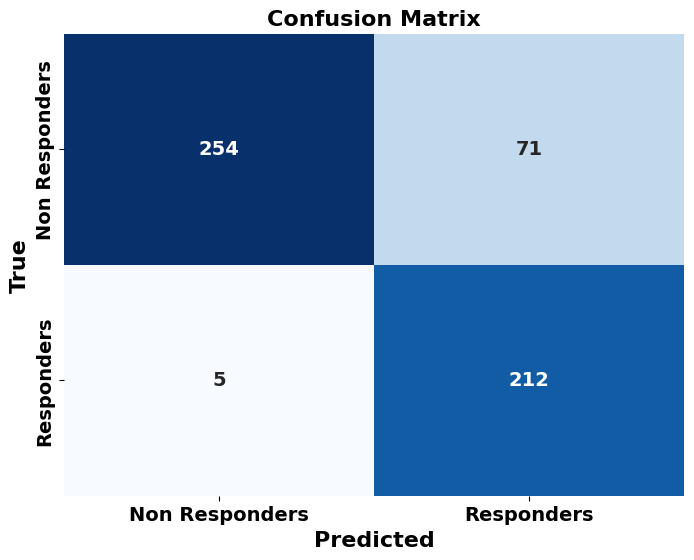

In [26]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14, "weight": "bold"})  # Increase font size and weight for values
    
    # Increase font size and make class labels bold
    ax.set_xticklabels(class_names, fontsize=14, weight='bold')
    ax.set_yticklabels(class_names, fontsize=14, weight='bold')
    
    plt.xlabel('Predicted', fontsize=16, weight='bold')  
    plt.ylabel('True', fontsize=16, weight='bold')  # Increase font size and weight for y label
    plt.title('Confusion Matrix', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

#  confusion matrix (conf_matrix) and class names
class_names = ['Non Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)


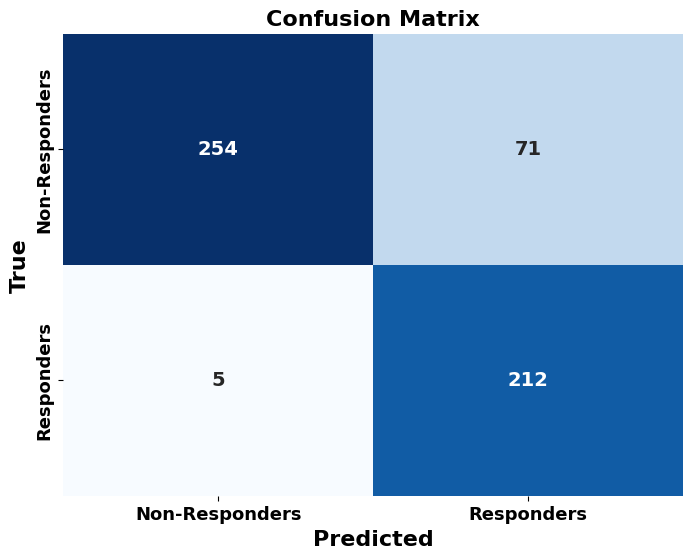

In [27]:
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14, "weight": "bold"})  # Increase font size and weight for values
    
    # Increase font size and make class labels bold
    ax.set_xticklabels(class_names, fontsize=13, weight='bold')
    ax.set_yticklabels(class_names, fontsize=13, weight='bold')
    
    plt.xlabel('Predicted', fontsize=16, weight='bold')  
    plt.ylabel('True', fontsize=16, weight='bold')  # Increase font size and weight for y label
    plt.title('Confusion Matrix', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

# confusion matrix (conf_matrix) and class names
class_names = ['Non-Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)


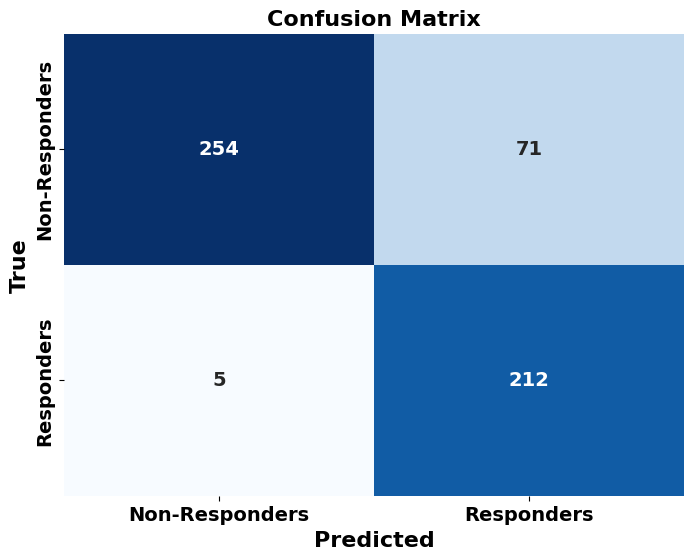

In [28]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Increase font size for true and predicted labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 14, "weight": "bold"})  # Increase font size and weight for values
    
    # Increase font size and make class labels bold
    ax.set_xticklabels(class_names, fontsize=14, weight='bold')
    ax.set_yticklabels(class_names, fontsize=14, weight='bold')
    
    plt.xlabel('Predicted', fontsize=16, weight='bold')  
    plt.ylabel('True', fontsize=16, weight='bold')  # Increase font size and weight for y label
    plt.title('Confusion Matrix', fontsize=16, weight='bold')  # Increase font size and weight for title
    plt.show()

# Assuming you already have the confusion matrix (conf_matrix) and class names
class_names = ['Non-Responders', 'Responders']
plot_confusion_matrix(conf_matrix, class_names)


In [29]:
print(evaluation_generator.classes)

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

In [30]:
# Get true labels
true_labels = evaluation_generator.classes

# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
predicted_labels = (evaluation_predictions > 0.5).astype(int)

# Initialize counters for correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

# Iterate over all predictions
for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / (correct_predictions + incorrect_predictions)

# Print the results
print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)
print("Accuracy:", accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
Correct Predictions: 466
Incorrect Predictions: 76
Accuracy: 0.8597785977859779


In [31]:
# confusion matrix (conf_matrix) and class names
class_names = ['Non_Responders', 'Responders']

# Print confusion matrix with counts
for i in range(len(class_names)):
    print(f"\nClass: {i} ({class_names[i]})")
    true_positives = conf_matrix[i, i]
    true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    print(f"True Positives (TP): {true_positives}")
    print(f"True Negatives (TN): {true_negatives}")
    print(f"False Positives (FP): {false_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print("====================")

# calculate and print overall metrics
overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Class: 0 (Non_Responders)
True Positives (TP): 254
True Negatives (TN): 212
False Positives (FP): 5
False Negatives (FN): 71

Class: 1 (Responders)
True Positives (TP): 212
True Negatives (TN): 254
False Positives (FP): 71
False Negatives (FN): 5

Overall Metrics:
Overall Accuracy: 0.8597785977859779
Precision: [0.98069498 0.74911661]
Recall: [0.78153846 0.97695853]


In [32]:
# confusion matrix (conf_matrix) and class names
class_names = ['Non_Responders', 'Responders']

# Print class-specific metrics
for i in range(len(class_names)):
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i]) if np.sum(conf_matrix[:, i]) != 0 else 0
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) != 0 else 0
    specificity = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(conf_matrix) - np.sum(conf_matrix[:, i]) - np.sum(conf_matrix[i, :]) + conf_matrix[i, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"\nClass: {class_names[i]}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print("====================")



Class: Non_Responders
Precision: 0.9807
Recall: 0.7815
Specificity: 1.0000
F1-score: 0.8699

Class: Responders
Precision: 0.7491
Recall: 0.9770
Specificity: 1.0000
F1-score: 0.8480


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


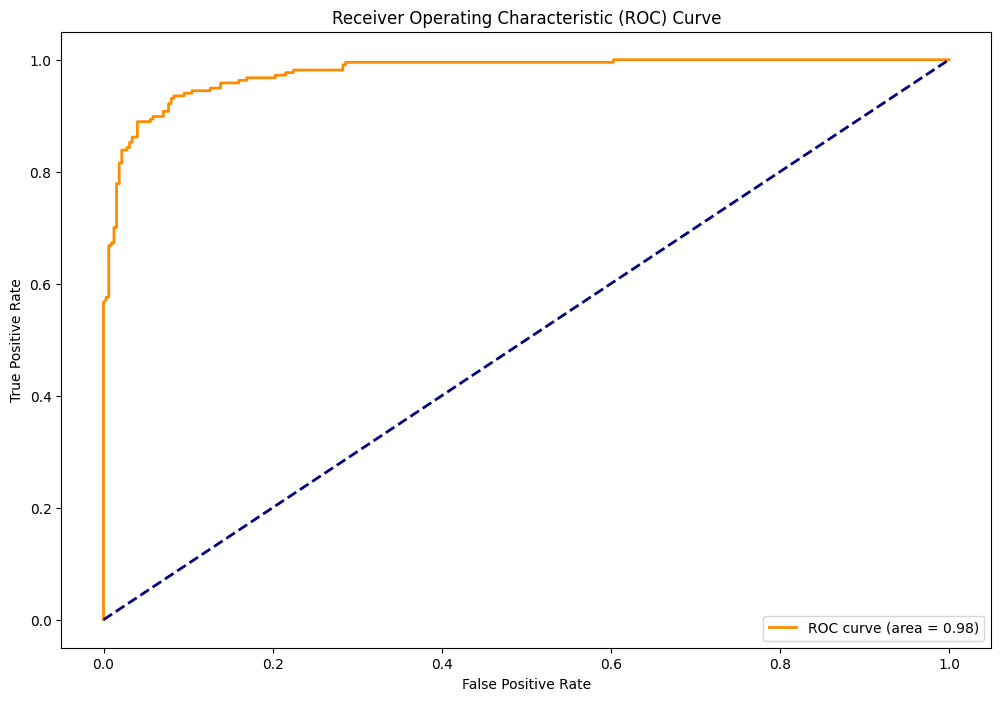

In [33]:
# true labels and predicted probabilities
true_labels = evaluation_generator.classes
predicted_probabilities = model.predict(evaluation_generator)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


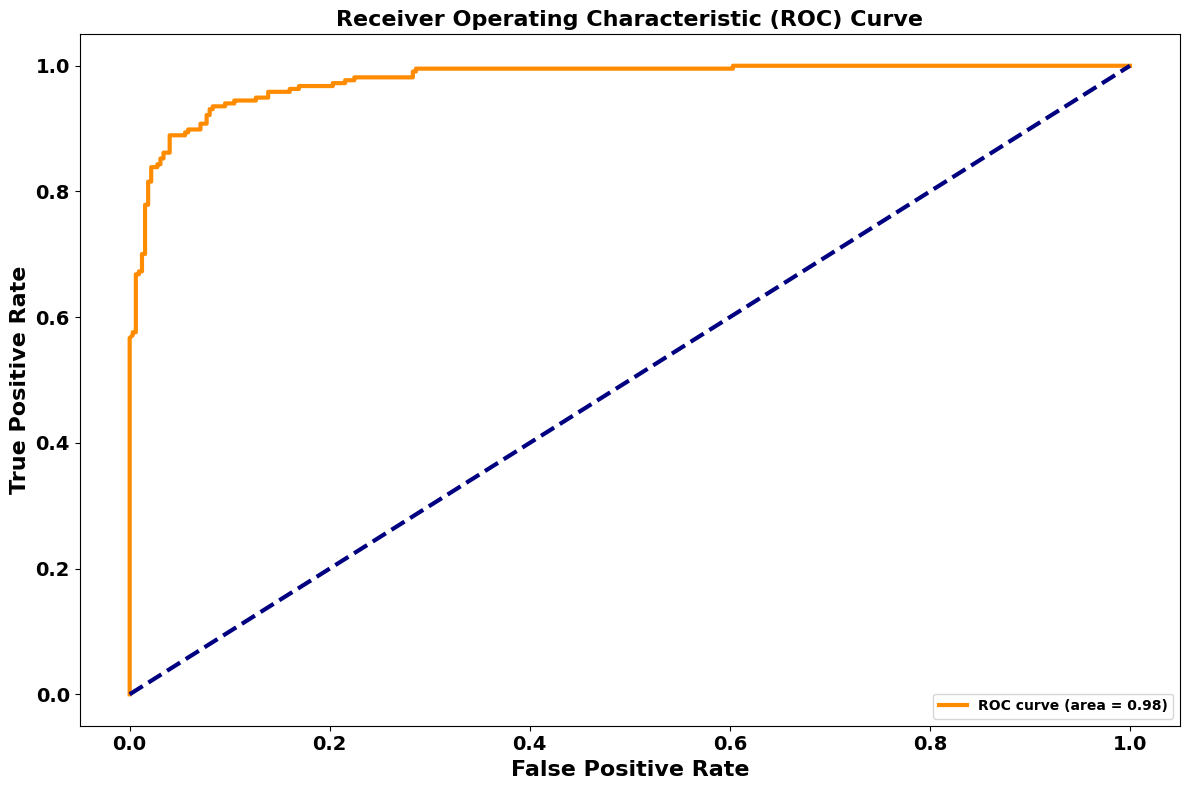

In [34]:
# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate', fontsize=16, weight='bold')  # Adjust x label properties
plt.ylabel('True Positive Rate', fontsize=16, weight='bold')  # Adjust y label properties
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, weight='bold')  # Adjust title properties
plt.legend(loc='lower right', fontsize=14, title_fontsize=14, fancybox=True, framealpha=0.7, edgecolor='black')  # Adjust legend properties
plt.xticks(fontsize=14, fontweight='bold')  # Increase font size of x ticks
plt.yticks(fontsize=14, fontweight='bold')  # Increase font size of y ticks

# Make text inside legend bold
legend = plt.legend(loc='lower right')
for text in legend.get_texts():
    text.set_weight('bold')

plt.tight_layout()

# # Save plot to local system
# plt.savefig('MDD_Xception_ROC.png')

plt.show()

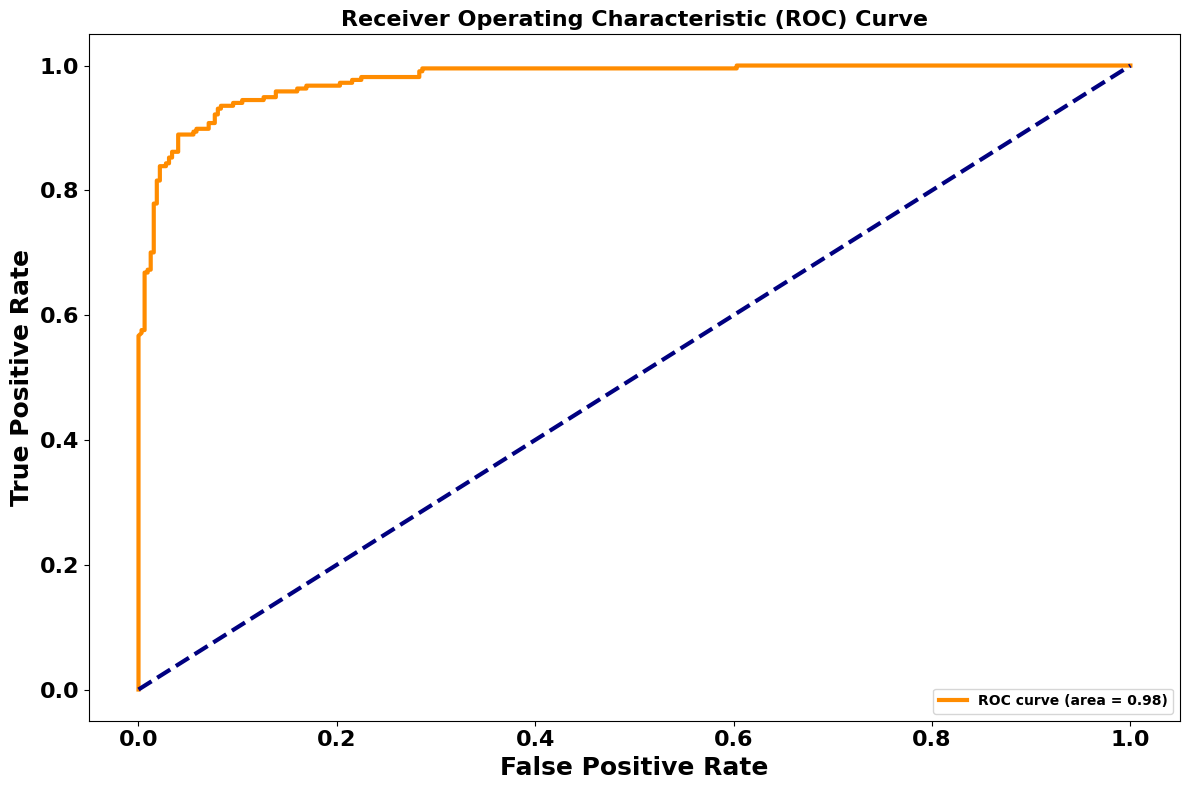

In [35]:
# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate', fontsize=18, weight='bold')  # Adjust x label properties
plt.ylabel('True Positive Rate', fontsize=18, weight='bold')  # Adjust y label properties
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, weight='bold')  # Adjust title properties
plt.legend(loc='lower right', fontsize=16, title_fontsize=16, fancybox=True, framealpha=0.7, edgecolor='black')  # Adjust legend properties
plt.xticks(fontsize=16, fontweight='bold')  # Increase font size of x ticks
plt.yticks(fontsize=16, fontweight='bold')  # Increase font size of y ticks

# Make text inside legend bold
legend = plt.legend(loc='lower right')
for text in legend.get_texts():
    text.set_weight('bold')

plt.tight_layout()

# # Save plot to local system
# plt.savefig('MDD_Xception_ROC.png')

plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


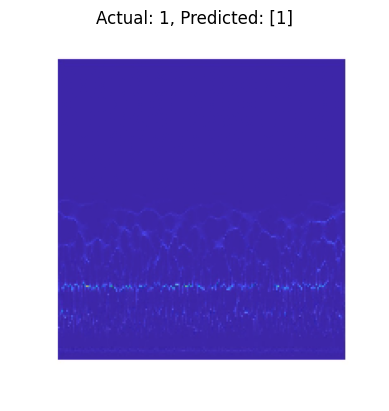

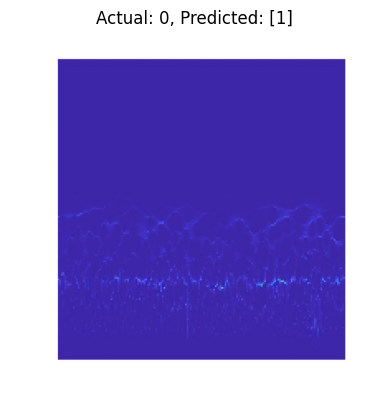

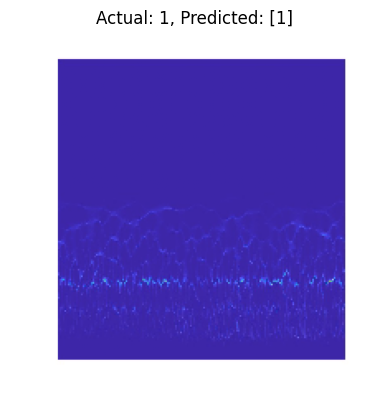

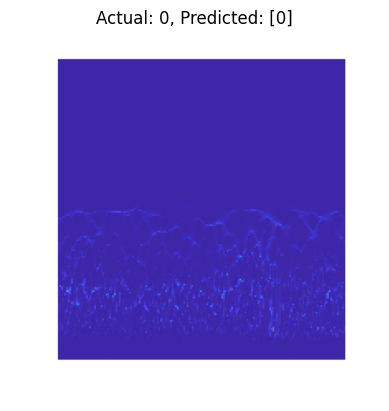

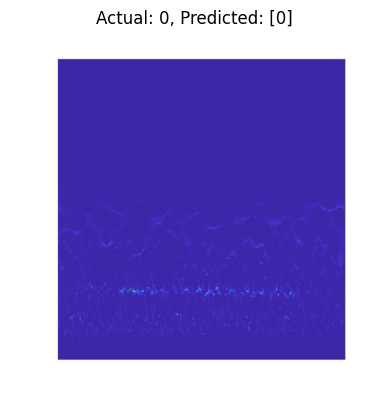

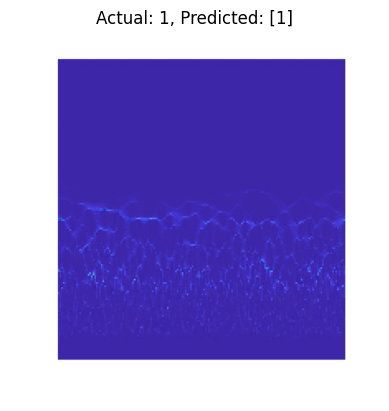

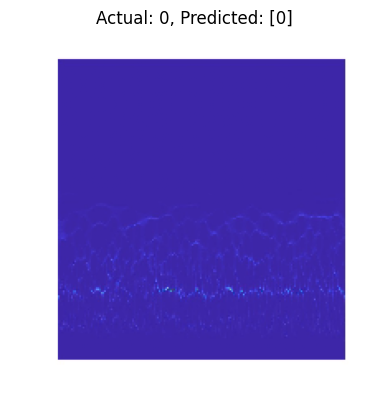

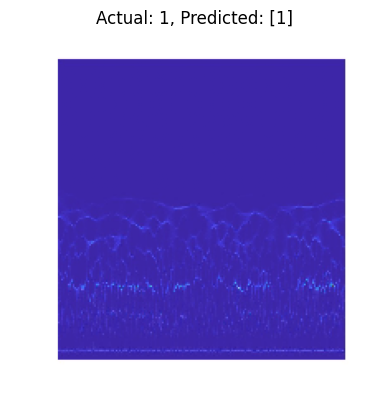

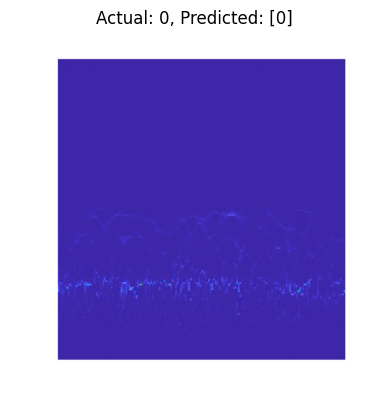

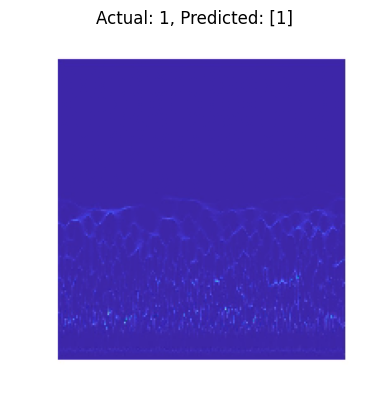

In [36]:
# Placeholder function for loading and preprocessing images
def load_and_preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to be between 0 and 1
    return img_array


# Get true labels
true_labels = evaluation_generator.classes

# Predict on the evaluation set
evaluation_predictions = model.predict(evaluation_generator)
predicted_labels = (evaluation_predictions > 0.5).astype(int)

# Display images along with actual and predicted labels
for i in range(len(true_labels[:10])):
    image_path = evaluation_set['path'].iloc[i]
    actual_label = true_labels[i]
    predicted_label = predicted_labels[i]

    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)

    # Display the image
    plt.imshow(image[0])  # Since image is a batch, select the first element
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


In [37]:
from tensorflow.keras.models import load_model

# Load the saved CNN model
loaded_model = load_model('/kaggle/working/MDD_Xception.h5')

# evaluation set
evaluation_set = test_df

# Evaluate the loaded model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model
evaluation_loss, evaluation_accuracy = loaded_model.evaluate(evaluation_generator)

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Found 542 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8776 - loss: 0.3760
Evaluation Loss: 0.4792933762073517
Evaluation Accuracy: 0.8597785830497742
